In [1]:
import warnings
warnings.filterwarnings('ignore')

import gseapy
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import sys
import time

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
expr_dir = "../../../misc/07__ENCODE_expr"

In [4]:
gene_sub = "w_gene"
tx_sub = "tx_only"

In [5]:
# seq_counts_f = "../../../data/00__rna_seq/00__sleuth_results/sleuth_abundances_raw_counts.TRANSCRIPTS_WITH_GENE_ISOFORM.txt"

In [6]:
gene_map_f = "../../../misc/00__gene_metadata/gencode.v25lift37.GENE_ID_TRANSCRIPT_ID_MAP.with_DIGIT.fixed.txt"

In [7]:
rna_seq_f = "../../../data/00__rna_seq/01__processed_results/rna_seq_results.tsv"

## 1. import data

In [8]:
files = [x[2] for x in os.walk(expr_dir)]
samps = set([x.split(".")[0] for x in files[0] if "kallisto" in x])
samps

{'A549_1_1',
 'A549_2_1',
 'A549_3_1',
 'A549_4_1',
 'GM12878_1_1',
 'GM12878_2_1',
 'H1_1_1',
 'HT1080_1_1',
 'HT1080_2_1',
 'HUES64_1_3',
 'IMR-90_1_1',
 'IMR-90_2_1',
 'K562_1_1',
 'K562_2_1',
 'MCF-7_3_1',
 'MCF-7_4_1',
 'NCI-H460_1_1',
 'NCI-H460_2_1',
 'SK-MEL-5_1_1',
 'SK-MEL-5_2_1',
 'SK-N-DZ_1_1',
 'SK-N-DZ_2_1',
 'SK-N-SH_3_1',
 'SK-N-SH_4_1'}

In [9]:
for i, samp in enumerate(samps):
    print(samp)
    tx_path = "%s/%s.%s.kallisto.tsv" % (expr_dir, samp, tx_sub)
    gene_path = "%s/%s.%s.kallisto.tsv" % (expr_dir, samp, gene_sub)
    if i == 0:
        tx_df = pd.read_table(tx_path, sep="\t")[["target_id", "tpm"]]
        tx_df.columns = ["target_id", samp]
        gene_df = pd.read_table(gene_path, sep="\t")[["target_id", "tpm"]]
        gene_df.columns = ["target_id", samp]
    else:
        tx_tmp = pd.read_table(tx_path, sep="\t")[["target_id", "tpm"]]
        tx_tmp.columns = ["target_id", samp]
        gene_tmp = pd.read_table(gene_path, sep="\t")[["target_id", "tpm"]]
        gene_tmp.columns = ["target_id", samp]
        
        tx_df = tx_df.merge(tx_tmp, on="target_id")
        gene_df = gene_df.merge(gene_tmp, on="target_id")

tx_df.head()

A549_4_1
K562_1_1
H1_1_1
NCI-H460_2_1
SK-N-DZ_1_1
SK-MEL-5_1_1
NCI-H460_1_1
SK-N-SH_4_1
HT1080_2_1
IMR-90_2_1
MCF-7_4_1
MCF-7_3_1
HUES64_1_3
A549_3_1
GM12878_2_1
SK-N-DZ_2_1
SK-N-SH_3_1
A549_1_1
HT1080_1_1
A549_2_1
K562_2_1
GM12878_1_1
IMR-90_1_1
SK-MEL-5_2_1


,target_id,A549_4_1,K562_1_1,H1_1_1,NCI-H460_2_1,SK-N-DZ_1_1,SK-MEL-5_1_1,NCI-H460_1_1,SK-N-SH_4_1,HT1080_2_1,...,GM12878_2_1,SK-N-DZ_2_1,SK-N-SH_3_1,A549_1_1,HT1080_1_1,A549_2_1,K562_2_1,GM12878_1_1,IMR-90_1_1,SK-MEL-5_2_1
0,ENST00000456328.2_1,0.763808,0.313936,0.004047,1.235340,4.806000,1.15116,0.659146,0.734967,0.691339,...,0.034047,5.64779,0.334105,0.573798,0.487667,0.156877,0.325951,0.017293,0.072287,0.769937
1,ENST00000450305.2_1,0.000000,0.000000,0.019143,0.341847,0.046717,0.00000,0.000000,0.000000,0.000000,...,0.031573,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002571,0.000000,0.048903
2,ENST00000488147.1_1,11.502300,13.862000,4.382520,38.673200,68.040800,40.79530,44.566400,19.772600,23.152300,...,3.035160,50.83590,18.962000,0.000000,22.800500,0.000000,13.735500,2.863410,15.670100,63.416700
3,ENST00000473358.1_1,0.000000,0.000000,0.028021,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.045354,0.000000,0.000000,0.000000,0.062664,0.000000,0.000000,0.000000
4,ENST00000469289.1_1,0.000000,0.033696,0.110995,0.000000,0.000000,0.00000,0.000000,0.035944,0.000000,...,0.009972,0.00000,0.000000,0.000000,0.000000,0.000000,0.033052,0.000000,0.000000,0.000000


In [10]:
# seq_counts = pd.read_table(seq_counts_f).reset_index()
# seq_counts.head()

In [11]:
gene_map = pd.read_table(gene_map_f, header=None)
gene_map.columns = ["gene_id", "transcript_id"]
gene_map.head()

,gene_id,transcript_id
0,ENSG00000223972.5_1,ENST00000456328.2_1
1,ENSG00000223972.5_1,ENST00000450305.2_1
2,ENSG00000227232.5_1,ENST00000488147.1_1
3,ENSG00000243485.4_2,ENST00000473358.1_1
4,ENSG00000243485.4_2,ENST00000469289.1_1


In [12]:
rna_seq = pd.read_table(rna_seq_f)
print(len(rna_seq))
rna_seq.head()

170623


,transcript_id,gene_id,gene_name,csf,cleaner_gene_biotype,cleaner_transcript_biotype,hESC_rep1,hESC_rep2,endo_rep1,endo_rep2,...,meso_rep2,hESC_mean,endo_mean,meso_mean,overall_mean,threshold,qval_hESC_endo,qval_hESC_meso,endo_hESC_log2fc,meso_hESC_log2fc
0,DIGIT,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap,promoter_overlap,0.000000,0.025422,4.907468,4.784695,...,0.014741,0.012711,4.846082,0.007370,1.622054,expressed,0.008168525422325441,sleuth NA,2.529248,-0.007628
1,ENST00000000233.9_1,ENSG00000004059.10_2,ARF5,protein_coding,protein_coding,protein_coding,101.476958,102.386195,222.677573,197.586091,...,245.318970,101.931577,210.131832,204.374142,172.145850,expressed,0.0057874417654439295,0.0346694249326972,1.036458,0.996569
2,ENST00000000412.3,ENSG00000003056.3,M6PR,protein_coding,protein_coding,protein_coding,49.696030,46.457026,31.608496,36.350968,...,10.951882,48.076528,33.979732,20.552771,34.203010,expressed,0.00549724038022104,0.13894723887027402,-0.488514,-1.187160
3,ENST00000000442.10_1,ENSG00000173153.13_2,ESRRA,protein_coding,protein_coding,protein_coding,1.924618,3.493033,3.499700,2.419880,...,7.769760,2.708826,2.959790,7.600094,4.422903,expressed,0.814911561863725,0.0241642757995681,0.094461,1.213390
4,ENST00000001008.5_1,ENSG00000004478.7_1,FKBP4,protein_coding,protein_coding,protein_coding,71.840722,79.489420,33.770398,33.810736,...,68.012268,75.665071,33.790567,61.985019,57.146886,expressed,0.00160853874236564,0.0935556001786738,-1.139873,-0.283561


## 2. sep gene & transcripts

In [13]:
gene_counts = gene_df[gene_df["target_id"].str.startswith("ENSG")]
print(len(gene_counts))
gene_counts.sample(5)

60203


,target_id,A549_4_1,K562_1_1,H1_1_1,NCI-H460_2_1,SK-N-DZ_1_1,SK-MEL-5_1_1,NCI-H460_1_1,SK-N-SH_4_1,HT1080_2_1,...,GM12878_2_1,SK-N-DZ_2_1,SK-N-SH_3_1,A549_1_1,HT1080_1_1,A549_2_1,K562_2_1,GM12878_1_1,IMR-90_1_1,SK-MEL-5_2_1
250042,ENSG00000230066.5_1::chrY:9334896-9344176(-),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001442,0.000000
232139,ENSG00000083544.13_2::chr13:60970590-61148012(+),0.026318,0.028148,0.025221,0.239706,0.115286,0.416561,0.149044,0.07698,0.146016,...,0.05719,0.118468,0.036314,0.033869,0.132155,0.02686,0.023689,0.054922,0.012707,0.414472
212835,ENSG00000223597.2_1::chr5:7373229-7379903(+),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
246372,ENSG00000182591.5_1::chr21:32252963-32253875(-),0.020310,0.000000,0.004515,0.000000,0.000000,0.032669,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.012957,0.000000,0.000000,0.00000,0.000000,0.000000,0.004574,0.000000
247050,ENSG00000253935.1_1::chr22:22574038-22574525(+),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


In [14]:
gene_counts = gene_counts.append(gene_df[gene_df["target_id"].str.contains("DIGIT::")])
print(len(gene_counts))

60204


In [15]:
transcript_counts = gene_df[gene_df["target_id"].str.startswith("ENST")]
print(len(transcript_counts))
transcript_counts.sample(5)

200139


,target_id,A549_4_1,K562_1_1,H1_1_1,NCI-H460_2_1,SK-N-DZ_1_1,SK-MEL-5_1_1,NCI-H460_1_1,SK-N-SH_4_1,HT1080_2_1,...,GM12878_2_1,SK-N-DZ_2_1,SK-N-SH_3_1,A549_1_1,HT1080_1_1,A549_2_1,K562_2_1,GM12878_1_1,IMR-90_1_1,SK-MEL-5_2_1
97645,ENST00000502161.6_1,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.022999,0.000000,...,0.073156,0.071750,0.048549,0.0,0.000000,0.000000,0.007496,0.014783,0.000000,0.000000
165675,ENST00000528059.1_1,0.032773,0.975492,0.362165,0.0,0.319043,0.00000,0.0,0.029940,0.024811,...,0.031460,0.000000,0.083639,0.0,0.325053,0.000000,0.819158,0.000000,0.008877,0.000000
13838,ENST00000255416.8_2,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.015455,0.000000,...,0.018436,0.000000,0.043335,0.0,0.000000,0.000000,0.000000,0.029581,0.000000,0.000000
44299,ENST00000510762.1_1,0.072184,0.236073,0.346634,0.0,0.000000,0.00000,0.0,0.090810,0.000000,...,0.187659,0.447893,0.050853,0.0,0.657279,0.223482,0.245856,0.097768,0.103514,0.438505
111361,ENST00000548706.1_1,0.000000,0.000000,0.000000,0.0,0.000000,3.93823,0.0,0.001041,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.017232,0.690473,0.012292,3.015130


In [16]:
transcript_counts = transcript_counts.append(gene_df[gene_df["target_id"] == "DIGIT"])
print(len(transcript_counts))

200140


## 4. make 1 dataframe with gene/transcript counts mapped to gene ids

In [17]:
gene_counts["gene_id"] = gene_counts["target_id"].str.split("::", expand=True)[0]
gene_counts["type"] = "gene"
gene_counts.head()

,target_id,A549_4_1,K562_1_1,H1_1_1,NCI-H460_2_1,SK-N-DZ_1_1,SK-MEL-5_1_1,NCI-H460_1_1,SK-N-SH_4_1,HT1080_2_1,...,SK-N-SH_3_1,A549_1_1,HT1080_1_1,A549_2_1,K562_2_1,GM12878_1_1,IMR-90_1_1,SK-MEL-5_2_1,gene_id,type
200140,ENSG00000223972.5_1::chr1:11868-14409(+),0.175356,0.152498,0.004712,0.276494,1.34005,0.0000,7.060170e-02,0.136682,0.018867,...,0.000000,0.000000,6.377350e-07,0.086909,0.000024,0.001038,0.059667,0.402920,ENSG00000223972.5_1,gene
200141,ENSG00000227232.5_1::chr1:14404-29571(-),1.476590,1.742750,0.807824,18.798600,19.51290,11.6066,1.747280e+01,8.522320,8.013650,...,6.811900,0.644312,7.090820e+00,0.843098,2.065460,0.531770,1.292600,14.212700,ENSG00000227232.5_1,gene
200142,ENSG00000243485.4_2::chr1:29553-31109(+),0.000000,0.080118,0.078441,0.000000,0.00000,0.0000,6.189830e-08,0.045724,0.077854,...,0.041129,0.000000,0.000000e+00,0.000000,0.063831,0.000000,0.000000,0.689376,ENSG00000243485.4_2,gene
200143,ENSG00000237613.2_1::chr1:34554-36082(-),0.000000,0.005424,0.000066,0.000000,0.00000,0.0000,0.000000e+00,0.000054,0.000000,...,0.000000,0.000000,1.410140e-03,0.000000,0.029432,0.000000,0.000105,0.000000,ENSG00000237613.2_1,gene
200144,ENSG00000268020.3_1::chr1:52472-53312(+),0.000000,0.004732,0.000000,0.000000,0.00000,0.0000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.011290,0.000000,0.000000,0.000000,ENSG00000268020.3_1,gene


In [18]:
transcript_counts["transcript_id"] = transcript_counts["target_id"]
transcript_counts["type"] = "transcript"
transcript_counts.head()

,target_id,A549_4_1,K562_1_1,H1_1_1,NCI-H460_2_1,SK-N-DZ_1_1,SK-MEL-5_1_1,NCI-H460_1_1,SK-N-SH_4_1,HT1080_2_1,...,SK-N-SH_3_1,A549_1_1,HT1080_1_1,A549_2_1,K562_2_1,GM12878_1_1,IMR-90_1_1,SK-MEL-5_2_1,transcript_id,type
0,ENST00000456328.2_1,0.275527,0.084567,0.000879,0.0000,0.001765,1.444350,0.733059,0.404552,0.262934,...,0.220057,0.359035,0.269616,0.0,0.093201,0.013761,0.0000,0.135529,ENST00000456328.2_1,transcript
1,ENST00000450305.2_1,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,ENST00000450305.2_1,transcript
2,ENST00000488147.1_1,14.017000,14.784400,5.105190,56.5208,88.337500,49.514600,62.705200,22.380200,28.958800,...,20.399800,0.000000,28.861400,0.0,15.014800,3.172690,16.9903,77.177500,ENST00000488147.1_1,transcript
3,ENST00000473358.1_1,0.000000,0.000000,0.000000,0.0000,0.000000,0.429972,0.000000,0.036563,0.000000,...,0.028681,0.000000,0.000000,0.0,0.037715,0.000000,0.0000,0.000000,ENST00000473358.1_1,transcript
4,ENST00000469289.1_1,0.000000,0.048793,0.000000,0.0000,0.000000,0.000000,0.000000,0.189307,0.000000,...,0.297624,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000,ENST00000469289.1_1,transcript


In [19]:
# cols = ["index", "type", "hESC_rep1", "hESC_rep2", "endo_rep1", "endo_rep2", "meso_rep1", "meso_rep2"]

In [20]:
tot_counts = gene_counts.append(transcript_counts)
tot_counts["id"] = tot_counts["target_id"].str.split("::", expand=True)[0]
tot_counts.drop(["gene_id", "transcript_id"], axis=1, inplace=True)
tot_counts.sample(5)

,A549_1_1,A549_2_1,A549_3_1,A549_4_1,GM12878_1_1,GM12878_2_1,H1_1_1,HT1080_1_1,HT1080_2_1,HUES64_1_3,...,NCI-H460_2_1,SK-MEL-5_1_1,SK-MEL-5_2_1,SK-N-DZ_1_1,SK-N-DZ_2_1,SK-N-SH_3_1,SK-N-SH_4_1,target_id,type,id
250579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,ENSG00000238705.1::chr1:26881032-26881084(+),gene,ENSG00000238705.1
248007,0.001523,0.001126,0.003038,0.002922,0.002244,0.001904,0.009758,0.014438,0.021905,1.516150e-03,...,0.002794,0.02297,2.055250e-02,0.007273,0.000840,0.000580,0.00130,ENSG00000146950.12_1::chrX:9754495-9917483(+),gene,ENSG00000146950.12_1
16903,79.887500,99.212900,79.239300,119.758000,33.313400,37.443400,10.243900,4.803880,5.922840,6.062730e+00,...,28.982500,27.13440,3.068600e+01,75.665300,70.891000,36.301200,39.96750,ENST00000396290.1_1,transcript,ENST00000396290.1_1
82465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.340984,0.000000,0.000000,0.000000e+00,...,0.000000,0.00000,0.000000e+00,0.285105,0.454248,0.053929,0.00000,ENST00000525376.1_1,transcript,ENST00000525376.1_1
111137,12.717100,15.451100,45.709600,42.476500,0.000000,0.000000,0.000000,12.469900,12.333800,6.753570e-09,...,1.535850,0.00000,2.954430e-08,0.000000,0.000000,6.127550,6.79547,ENST00000313234.9_1,transcript,ENST00000313234.9_1


In [21]:
tot_counts = tot_counts.merge(gene_map, left_on="id", right_on="transcript_id", how="left")
tot_counts.sample(5)

,A549_1_1,A549_2_1,A549_3_1,A549_4_1,GM12878_1_1,GM12878_2_1,H1_1_1,HT1080_1_1,HT1080_2_1,HUES64_1_3,...,SK-MEL-5_2_1,SK-N-DZ_1_1,SK-N-DZ_2_1,SK-N-SH_3_1,SK-N-SH_4_1,target_id,type,id,gene_id,transcript_id
103911,0.0000,0.00000,0.009275,0.000000e+00,0.000000,0.000000,0.349987,0.000000,0.000000,0.023219,...,0.000000,0.000,0.000000,0.007305,0.000000,ENST00000423784.5_1,transcript,ENST00000423784.5_1,ENSG00000179299.16_2,ENST00000423784.5_1
153689,3.4121,3.37615,0.023908,6.461220e-02,0.534258,3.709990,0.182988,0.269386,0.710391,0.004470,...,0.000000,0.000,0.041969,0.082376,0.177493,ENST00000467116.5_1,transcript,ENST00000467116.5_1,ENSG00000077150.18_2,ENST00000467116.5_1
225520,0.0000,0.00000,0.000000,0.000000e+00,0.885967,0.774016,0.435085,0.000000,0.000000,0.000000,...,0.000000,0.000,0.000000,0.013269,0.000000,ENST00000589668.1_1,transcript,ENST00000589668.1_1,ENSG00000256771.2_2,ENST00000589668.1_1
71842,0.0000,0.00000,0.000000,1.891570e-07,1.302540,0.605978,0.000000,0.117013,0.000000,0.000000,...,0.041998,0.000,0.000000,0.000000,0.000000,ENST00000444090.6_1,transcript,ENST00000444090.6_1,ENSG00000026751.16_1,ENST00000444090.6_1
184167,123.4400,110.70500,72.888100,9.400640e+01,371.046000,395.392000,57.628400,198.535000,182.917000,13.013600,...,117.914000,129.484,134.818000,69.315500,83.887700,ENST00000216455.8_1,transcript,ENST00000216455.8_1,ENSG00000100567.12_2,ENST00000216455.8_1


In [22]:
def fill_gene_id(row):
    if pd.isnull(row["gene_id"]):
        return row["id"]
    else:
        return row["gene_id"]
    
tot_counts["gene_id"] = tot_counts.apply(fill_gene_id, axis=1)
tot_counts.sample(5)

,A549_1_1,A549_2_1,A549_3_1,A549_4_1,GM12878_1_1,GM12878_2_1,H1_1_1,HT1080_1_1,HT1080_2_1,HUES64_1_3,...,SK-MEL-5_2_1,SK-N-DZ_1_1,SK-N-DZ_2_1,SK-N-SH_3_1,SK-N-SH_4_1,target_id,type,id,gene_id,transcript_id
10652,0.083461,0.158110,0.341451,0.303420,0.115714,0.134498,0.240117,0.522963,0.345689,0.022692,...,0.424185,0.39017,0.624252,0.236745,0.562434,ENSG00000261490.1_1::chr4:10069713-10074644(-),gene,ENSG00000261490.1_1,ENSG00000261490.1_1,NaN
146169,0.000000,0.528451,0.000000,0.000601,0.017121,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.033830,0.000000,ENST00000525847.1_1,transcript,ENST00000525847.1_1,ENSG00000136874.10_2,ENST00000525847.1_1
179750,14.846100,17.593900,3.982760,7.240720,5.113780,5.604840,4.827910,19.276500,19.112200,0.755996,...,4.818260,4.55220,5.026680,2.946290,3.287200,ENST00000400324.8_1,transcript,ENST00000400324.8_1,ENSG00000139734.17_2,ENST00000400324.8_1
212891,0.556457,0.348578,0.267768,0.311173,0.526496,0.640977,0.545047,0.641801,0.724212,0.045973,...,0.147664,2.87323,2.891460,1.400810,0.959329,ENST00000416263.3_1,transcript,ENST00000416263.3_1,ENSG00000229980.4_1,ENST00000416263.3_1
85959,26.513200,16.791700,2.475270,3.511280,2.393930,7.346230,0.069037,0.054149,0.000000,0.000000,...,1.088290,0.00000,1.563710,5.109500,14.790500,ENST00000443241.5_1,transcript,ENST00000443241.5_1,ENSG00000128654.13_1,ENST00000443241.5_1


In [23]:
cols = ["id", "gene_id", "type"]
cols.extend(samps)

tot_counts = tot_counts[cols]
tot_counts = tot_counts.sort_values(by="gene_id")
tot_counts.head()

,id,gene_id,type,A549_4_1,K562_1_1,H1_1_1,NCI-H460_2_1,SK-N-DZ_1_1,SK-MEL-5_1_1,NCI-H460_1_1,...,GM12878_2_1,SK-N-DZ_2_1,SK-N-SH_3_1,A549_1_1,HT1080_1_1,A549_2_1,K562_2_1,GM12878_1_1,IMR-90_1_1,SK-MEL-5_2_1
260343,DIGIT,DIGIT,transcript,0.000000,0.000000,0.007726,0.00000,0.000000,0.000000,0.837391,...,0.000000,0.000000,0.023549,0.000000,0.000000,0.00000,0.00000,0.00000,0.002972,0.000000
60203,DIGIT,DIGIT,gene,0.000000,0.000000,0.000000,0.41413,0.000000,0.000000,0.027587,...,0.000000,0.004493,0.011484,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000
246632,ENST00000373020.8_1,ENSG00000000003.14_1,transcript,46.086500,0.006845,33.727600,28.67390,0.599449,23.240900,23.166600,...,0.010455,0.829867,15.125800,129.732000,12.789700,151.10100,0.01231,0.00834,7.668360,24.082400
246633,ENST00000614008.4_1,ENSG00000000003.14_1,transcript,0.412471,0.000000,0.165611,2.72007,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.587522,0.704090,0.00000,0.00000,0.00000,0.000000,0.728174
246634,ENST00000496771.5_1,ENSG00000000003.14_1,transcript,1.421460,0.005505,0.337274,1.32613,1.071130,0.537843,3.728680,...,0.000000,0.776435,1.315480,1.581980,0.190501,1.56364,0.00000,0.00000,0.268577,1.732210


## 5. sum counts per gene (incl. gene isoform and all transcripts)

In [24]:
sum_counts = tot_counts.groupby("gene_id")[list(samps)].agg("sum").reset_index()
sum_counts.head()

,gene_id,A549_4_1,K562_1_1,H1_1_1,NCI-H460_2_1,SK-N-DZ_1_1,SK-MEL-5_1_1,NCI-H460_1_1,SK-N-SH_4_1,HT1080_2_1,...,GM12878_2_1,SK-N-DZ_2_1,SK-N-SH_3_1,A549_1_1,HT1080_1_1,A549_2_1,K562_2_1,GM12878_1_1,IMR-90_1_1,SK-MEL-5_2_1
0,DIGIT,0.000000,0.000000,0.007726,0.414130,0.000000,0.000000,0.864978,0.039987,0.000000,...,0.000000,0.004493,0.035033,0.000000,0.000000,0.000000,0.000000,0.000000,0.002972,0.000000
1,ENSG00000000003.14_1,48.139152,0.012643,35.839692,33.688683,1.751627,24.246197,28.055113,19.244910,14.541504,...,0.011580,1.686872,16.992889,133.533676,13.817025,154.010289,0.012310,0.016676,8.275706,26.945229
2,ENSG00000000005.5_1,0.000904,0.000000,2.058903,0.000000,0.000000,0.000000,0.000000,0.004447,0.000000,...,0.000000,0.000000,0.000163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000391,0.000000
3,ENSG00000000419.12_1,44.527992,135.290452,28.357671,124.338954,246.059250,71.949707,181.760640,80.868613,136.635031,...,87.882893,300.970130,69.637735,69.847103,134.609196,81.122964,130.180814,87.818252,42.575755,71.786449
4,ENSG00000000457.13_1,3.468668,3.939202,1.757401,10.623403,10.351289,9.618897,6.859320,8.004585,8.792988,...,6.201278,9.435939,6.872076,7.024126,8.442258,7.501861,4.208993,5.654283,2.204203,7.121389


## 6. calculate splicing efficiency

In [25]:
len(gene_counts)

60204

In [26]:
len(sum_counts)

60253

In [27]:
data = gene_counts.merge(sum_counts, on="gene_id", suffixes=("_gene", "_tot"))
data.head()

,target_id,A549_4_1_gene,K562_1_1_gene,H1_1_1_gene,NCI-H460_2_1_gene,SK-N-DZ_1_1_gene,SK-MEL-5_1_1_gene,NCI-H460_1_1_gene,SK-N-SH_4_1_gene,HT1080_2_1_gene,...,GM12878_2_1_tot,SK-N-DZ_2_1_tot,SK-N-SH_3_1_tot,A549_1_1_tot,HT1080_1_1_tot,A549_2_1_tot,K562_2_1_tot,GM12878_1_1_tot,IMR-90_1_1_tot,SK-MEL-5_2_1_tot
0,ENSG00000223972.5_1::chr1:11868-14409(+),0.175356,0.152498,0.004712,0.276494,1.34005,0.0000,7.060170e-02,0.136682,0.018867,...,0.018448,2.637289,0.220057,0.359035,0.269617,0.086909,0.093225,0.014799,0.059667,0.538449
1,ENSG00000227232.5_1::chr1:14404-29571(-),1.476590,1.742750,0.807824,18.798600,19.51290,11.6066,1.747280e+01,8.522320,8.013650,...,4.109153,80.792600,27.211700,0.644312,35.952220,0.843098,17.080260,3.704460,18.282900,91.390200
2,ENSG00000243485.4_2::chr1:29553-31109(+),0.000000,0.080118,0.078441,0.000000,0.00000,0.0000,6.189830e-08,0.045724,0.077854,...,0.102194,0.495686,0.367433,0.000000,0.000000,0.000000,0.101546,0.000000,0.000000,0.689376
3,ENSG00000237613.2_1::chr1:34554-36082(-),0.000000,0.005424,0.000066,0.000000,0.00000,0.0000,0.000000e+00,0.000054,0.000000,...,0.000000,0.000000,0.000010,0.000000,0.021930,0.000000,0.053963,0.000000,0.178666,0.000000
4,ENSG00000268020.3_1::chr1:52472-53312(+),0.000000,0.004732,0.000000,0.000000,0.00000,0.0000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022581,0.000000,0.000000,0.000000


In [28]:
for samp in samps:
    data["%s_eff" % samp] = 1-((data["%s_gene" % samp]+1)/(data["%s_tot" % samp]+1))
data.head()

,target_id,A549_4_1_gene,K562_1_1_gene,H1_1_1_gene,NCI-H460_2_1_gene,SK-N-DZ_1_1_gene,SK-MEL-5_1_1_gene,NCI-H460_1_1_gene,SK-N-SH_4_1_gene,HT1080_2_1_gene,...,GM12878_2_1_eff,SK-N-DZ_2_1_eff,SK-N-SH_3_1_eff,A549_1_1_eff,HT1080_1_1_eff,A549_2_1_eff,K562_2_1_eff,GM12878_1_1_eff,IMR-90_1_1_eff,SK-MEL-5_2_1_eff
0,ENSG00000223972.5_1::chr1:11868-14409(+),0.175356,0.152498,0.004712,0.276494,1.34005,0.0000,7.060170e-02,0.136682,0.018867,...,0.002383,0.494277,0.180366,0.264184,0.212360,0.0,0.085253,0.013561,0.000000,0.088095
1,ENSG00000227232.5_1::chr1:14404-29571(-),1.476590,1.742750,0.807824,18.798600,19.51290,11.6066,1.747280e+01,8.522320,8.013650,...,0.679048,0.796466,0.723097,0.000000,0.781046,0.0,0.830453,0.674400,0.881107,0.835343
2,ENSG00000243485.4_2::chr1:29553-31109(+),0.000000,0.080118,0.078441,0.000000,0.00000,0.0000,6.189830e-08,0.045724,0.077854,...,0.092719,0.331410,0.238626,0.000000,0.000000,0.0,0.034238,0.000000,0.000000,0.000000
3,ENSG00000237613.2_1::chr1:34554-36082(-),0.000000,0.005424,0.000066,0.000000,0.00000,0.0000,0.000000e+00,0.000054,0.000000,...,0.000000,0.000000,0.000010,0.000000,0.020079,0.0,0.023275,0.000000,0.151494,0.000000
4,ENSG00000268020.3_1::chr1:52472-53312(+),0.000000,0.004732,0.000000,0.000000,0.00000,0.0000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.011041,0.000000,0.000000,0.000000


In [29]:
cells = set([x.split("_")[0] for x in samps])
cells

{'A549',
 'GM12878',
 'H1',
 'HT1080',
 'HUES64',
 'IMR-90',
 'K562',
 'MCF-7',
 'NCI-H460',
 'SK-MEL-5',
 'SK-N-DZ',
 'SK-N-SH'}

In [30]:
for cell in cells:
    sub_cols = ["%s_eff" % x for x in samps if cell in x]
    print("cell: %s, samps: %s" % (cell, sub_cols))
    data["%s_eff_mean" % cell] = data[sub_cols].mean(axis=1)
    sub_cols = ["%s_tot" % x for x in samps if cell in x]
    data["%s_exp_mean" % cell] = data[sub_cols].mean(axis=1)
    
    # also record the ratio of expr & splicing efficiency (eff * expr)
    data["%s_eff_ratio" % cell] = data["%s_eff_mean" % cell] * data["%s_exp_mean" % cell]
data.head()

cell: IMR-90, samps: ['IMR-90_2_1_eff', 'IMR-90_1_1_eff']
cell: K562, samps: ['K562_1_1_eff', 'K562_2_1_eff']
cell: HT1080, samps: ['HT1080_2_1_eff', 'HT1080_1_1_eff']
cell: HUES64, samps: ['HUES64_1_3_eff']
cell: H1, samps: ['H1_1_1_eff']
cell: SK-N-DZ, samps: ['SK-N-DZ_1_1_eff', 'SK-N-DZ_2_1_eff']
cell: GM12878, samps: ['GM12878_2_1_eff', 'GM12878_1_1_eff']
cell: SK-N-SH, samps: ['SK-N-SH_4_1_eff', 'SK-N-SH_3_1_eff']
cell: A549, samps: ['A549_4_1_eff', 'A549_3_1_eff', 'A549_1_1_eff', 'A549_2_1_eff']
cell: SK-MEL-5, samps: ['SK-MEL-5_1_1_eff', 'SK-MEL-5_2_1_eff']
cell: NCI-H460, samps: ['NCI-H460_2_1_eff', 'NCI-H460_1_1_eff']
cell: MCF-7, samps: ['MCF-7_4_1_eff', 'MCF-7_3_1_eff']


,target_id,A549_4_1_gene,K562_1_1_gene,H1_1_1_gene,NCI-H460_2_1_gene,SK-N-DZ_1_1_gene,SK-MEL-5_1_1_gene,NCI-H460_1_1_gene,SK-N-SH_4_1_gene,HT1080_2_1_gene,...,A549_eff_ratio,SK-MEL-5_eff_mean,SK-MEL-5_exp_mean,SK-MEL-5_eff_ratio,NCI-H460_eff_mean,NCI-H460_exp_mean,NCI-H460_eff_ratio,MCF-7_eff_mean,MCF-7_exp_mean,MCF-7_eff_ratio
0,ENSG00000223972.5_1::chr1:11868-14409(+),0.175356,0.152498,0.004712,0.276494,1.34005,0.0000,7.060170e-02,0.136682,0.018867,...,0.053717,0.339494,0.991399,0.336574,0.203214,5.400774e-01,0.109751,0.313201,0.596699,0.186887
1,ENSG00000227232.5_1::chr1:14404-29571(-),1.476590,1.742750,0.807824,18.798600,19.51290,11.6066,1.747280e+01,8.522320,8.013650,...,4.235293,0.816204,76.255700,62.240184,0.756512,7.774870e+01,58.817792,0.823440,58.351755,48.049186
2,ENSG00000243485.4_2::chr1:29553-31109(+),0.000000,0.080118,0.078441,0.000000,0.00000,0.0000,6.189830e-08,0.045724,0.077854,...,0.000137,0.150343,0.559674,0.084143,0.000000,3.094915e-08,0.000000,0.041777,0.045585,0.001904
3,ENSG00000237613.2_1::chr1:34554-36082(-),0.000000,0.005424,0.000066,0.000000,0.00000,0.0000,0.000000e+00,0.000054,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
4,ENSG00000268020.3_1::chr1:52472-53312(+),0.000000,0.004732,0.000000,0.000000,0.00000,0.0000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000


In [31]:
data["gene_id"] = data.target_id.str.split("::", expand=True)[0]

clean_cols = ["gene_id"]
clean_cols.extend([x for x in data.columns if "_mean" in x or "_ratio" in x])
data = data[clean_cols]
data.head()

,gene_id,IMR-90_eff_mean,IMR-90_exp_mean,IMR-90_eff_ratio,K562_eff_mean,K562_exp_mean,K562_eff_ratio,HT1080_eff_mean,HT1080_exp_mean,HT1080_eff_ratio,...,A549_eff_ratio,SK-MEL-5_eff_mean,SK-MEL-5_exp_mean,SK-MEL-5_eff_ratio,NCI-H460_eff_mean,NCI-H460_exp_mean,NCI-H460_eff_ratio,MCF-7_eff_mean,MCF-7_exp_mean,MCF-7_eff_ratio
0,ENSG00000223972.5_1,0.013085,0.043270,0.000566,0.076807,0.165145,0.012684,0.208744,0.275709,0.057553,...,0.053717,0.339494,0.991399,0.336574,0.203214,5.400774e-01,0.109751,0.313201,0.596699,0.186887
1,ENSG00000227232.5_1,0.894381,19.902825,17.800715,0.836983,16.803705,14.064423,0.771837,36.462335,28.142962,...,4.235293,0.816204,76.255700,62.240184,0.756512,7.774870e+01,58.817792,0.823440,58.351755,48.049186
2,ENSG00000243485.4_2,0.000000,0.000000,0.000000,0.038730,0.115228,0.004463,0.000000,0.038927,0.000000,...,0.000137,0.150343,0.559674,0.084143,0.000000,3.094915e-08,0.000000,0.041777,0.045585,0.001904
3,ENSG00000237613.2_1,0.075812,0.089398,0.006777,0.014606,0.032696,0.000478,0.010058,0.010983,0.000110,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
4,ENSG00000268020.3_1,0.000000,0.000000,0.000000,0.007864,0.016022,0.000126,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000


## 7. merge w/ biotype info

In [32]:
biotypes = rna_seq[["gene_id", "gene_name", "csf", "cleaner_gene_biotype"]].drop_duplicates()
print(len(biotypes))
biotypes.head()

33856


,gene_id,gene_name,csf,cleaner_gene_biotype
0,DIGIT,DIGIT,lncRNA_good_csf,promoter_overlap
1,ENSG00000004059.10_2,ARF5,protein_coding,protein_coding
2,ENSG00000003056.3,M6PR,protein_coding,protein_coding
3,ENSG00000173153.13_2,ESRRA,protein_coding,protein_coding
4,ENSG00000004478.7_1,FKBP4,protein_coding,protein_coding


In [33]:
data = data.merge(biotypes, on="gene_id", how="left")
print(len(data))
data.sample(5)

60204


,gene_id,IMR-90_eff_mean,IMR-90_exp_mean,IMR-90_eff_ratio,K562_eff_mean,K562_exp_mean,K562_eff_ratio,HT1080_eff_mean,HT1080_exp_mean,HT1080_eff_ratio,...,SK-MEL-5_eff_ratio,NCI-H460_eff_mean,NCI-H460_exp_mean,NCI-H460_eff_ratio,MCF-7_eff_mean,MCF-7_exp_mean,MCF-7_eff_ratio,gene_name,csf,cleaner_gene_biotype
53201,ENSG00000212215.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
18931,ENSG00000242950.6_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.268599,0.580375,0.155888,0.000000,0.000000,0.000000,ERVW-1,protein_coding,protein_coding
28315,ENSG00000230911.1_1,0.003930,0.007986,0.000031,0.009587,0.055611,0.000533,0.043057,0.095047,0.004092,...,0.00000,0.000000,0.000000,0.000000,0.005099,0.010410,0.000053,NaN,NaN,NaN
9655,ENSG00000240032.1_1,0.026792,0.063446,0.001700,0.000000,0.000000,0.000000,0.254669,0.442785,0.112763,...,0.05801,0.000000,0.000000,0.000000,0.052666,0.058866,0.003100,RP11-274H2.3,lncRNA_good_csf,transcript_overlap
52309,ENSG00000199286.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN


## 9. some QC plots

In [34]:
data.cleaner_gene_biotype.value_counts()

protein_coding        20132
transcript_overlap     6594
intergenic             4615
promoter_overlap       2262
gene_nearby             253
Name: cleaner_gene_biotype, dtype: int64

In [35]:
order = ["protein_coding", "intergenic", "promoter_overlap", "transcript_overlap", "gene_nearby"]
pal = {"protein_coding": sns.color_palette("deep")[0], "intergenic": "firebrick", "promoter_overlap": "firebrick",
       "transcript_overlap": "firebrick", "gene_nearby": "firebrick"}

In [36]:
sorted(list(cells))

['A549',
 'GM12878',
 'H1',
 'HT1080',
 'HUES64',
 'IMR-90',
 'K562',
 'MCF-7',
 'NCI-H460',
 'SK-MEL-5',
 'SK-N-DZ',
 'SK-N-SH']

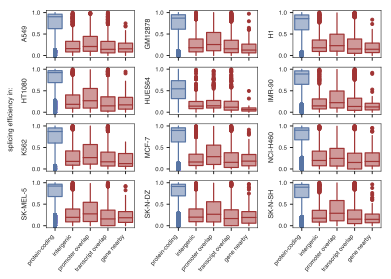

In [37]:
fig, axarr = plt.subplots(figsize=(6, 4), nrows=4, ncols=3, sharex=True)

c = 0
for i in range(4):
    for j in range(3):
        col = sorted(list(cells))[c]

        sub = data[data["%s_exp_mean" % col] >= 0.1]
        ax = axarr[i, j]

        sns.boxplot(data=sub, x="cleaner_gene_biotype", y="%s_eff_mean" % col, order=order, palette=pal,
                    flierprops=dict(marker='o', markersize=3), ax=ax)
        mimic_r_boxplot(ax)

        ax.set_xlabel("")
        ax.set_ylabel(col)
        ax.set_xticklabels(["protein-coding", "intergenic", "promoter overlap", "transcript overlap", "gene nearby"],
                           rotation=50, ha="right", va="top")
        c += 1

plt.subplots_adjust(wspace=0.4)
plt.text(0.05, 0.5, 'splicing efficiency in:',
         horizontalalignment='right',
         verticalalignment='center',
         rotation='vertical',
         transform=plt.gcf().transFigure)

fig.savefig("splicing_eff_boxplot.pdf", dpi="figure", bbox_inches="tight")

In [38]:
eff_cols = [x for x in data.columns if "eff" in x and "ratio" not in x]
exp_cols = [x for x in data.columns if "exp" in x]
ratio_cols = [x for x in data.columns if "ratio" in x]

data["max_eff"] = data[eff_cols].max(axis=1)
data["max_exp"] = data[exp_cols].max(axis=1)
data["max_ratio"] = data[ratio_cols].max(axis=1)
data.head()

,gene_id,IMR-90_eff_mean,IMR-90_exp_mean,IMR-90_eff_ratio,K562_eff_mean,K562_exp_mean,K562_eff_ratio,HT1080_eff_mean,HT1080_exp_mean,HT1080_eff_ratio,...,NCI-H460_eff_ratio,MCF-7_eff_mean,MCF-7_exp_mean,MCF-7_eff_ratio,gene_name,csf,cleaner_gene_biotype,max_eff,max_exp,max_ratio
0,ENSG00000223972.5_1,0.013085,0.043270,0.000566,0.076807,0.165145,0.012684,0.208744,0.275709,0.057553,...,0.109751,0.313201,0.596699,0.186887,NaN,NaN,NaN,0.339494,1.989552,0.492445
1,ENSG00000227232.5_1,0.894381,19.902825,17.800715,0.836983,16.803705,14.064423,0.771837,36.462335,28.142962,...,58.817792,0.823440,58.351755,48.049186,NaN,NaN,NaN,0.894381,94.321500,75.835208
2,ENSG00000243485.4_2,0.000000,0.000000,0.000000,0.038730,0.115228,0.004463,0.000000,0.038927,0.000000,...,0.000000,0.041777,0.045585,0.001904,MIR1302-2,lncRNA_good_csf,intergenic,0.208126,0.559674,0.084143
3,ENSG00000237613.2_1,0.075812,0.089398,0.006777,0.014606,0.032696,0.000478,0.010058,0.010983,0.000110,...,0.000000,0.000000,0.000000,0.000000,FAM138A,lncRNA_good_csf,intergenic,0.154032,0.222609,0.034289
4,ENSG00000268020.3_1,0.000000,0.000000,0.000000,0.007864,0.016022,0.000126,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.007864,0.016022,0.000126


## 10. write file

In [39]:
data_f = "../../../misc/08__model_features/gene_splicing_efficiency.with_DIGIT.txt"
data.to_csv(data_f, index=False, sep="\t")